#### 필요 라이브러리, 데이터셋 import

In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys, os
sys.path.append(os.pardir)

from dataset.mnist import load_mnist

In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

## --사용 함수--
----

### 활성화 함수
- 시그모이드
- 소프트맥스 (크기에 맞게 변경)

### 손실 함수
- 교차 엔트로피 오차

### 기울기
- 편미분, 수치 미분 --> 기울기

In [3]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

In [4]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [5]:
def relu(x):
    return np.maximum(0, x)

In [6]:
def relu_grad(x):
    print(x.shape)
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [8]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# SGD 클래스

In [9]:
class SGD:
    def __init__(self, Ir=0.01):
        self.Ir =Ir
        print("SGD 생성")

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.Ir * grads[key]

# Momentum 클래스

In [10]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        print("Momentum 생성")

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

# AdaGrad 클래스

In [11]:
class AdaGrad:
    def __init__ (self, Ir=0.01):
        self.Ir =Ir
        self.h = None
        print("AdaGrad 생성")
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.Ir * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


```python
# 기존에 0.01을 곱하여 사용한 가중치 초기화
        # 첫 번째 층
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size[0])
        self.params['b1'] = np.zeros(hidden_size[0])

        # 중간 층
        for i in range(1, self.maxIndex - 1):
            self.params['W' + str(i + 1)] = weight_init_std * np.random.randn(hidden_size[i - 1], hidden_size[i])
            self.params['b' + str(i + 1)] = np.zeros(hidden_size[i])

        # 마지막 층
        self.params['W' + str(self.maxIndex)] = weight_init_std * np.random.randn(hidden_size[-1], output_size)
        self.params['b' + str(self.maxIndex)] = np.zeros(output_size)
```

In [12]:
def xavier_initializer(fan_in, fan_out, gain=np.sqrt(2.0)):
    range = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.randn(fan_in, fan_out) * gain * range

## 학습에 사용될 클래스

In [13]:
class TwoLayerNet:

    # 가중치 초기화
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.1):
        self.params = {}
        self.maxIndex = len(hidden_size)  # 입력층, 출력층 포함
        
        node_num = input_size
        
        # 첫 번째 층
        self.params['W1'] = np.random.randn(input_size, hidden_size[0]) * weight_init_std
        self.params['b1'] = np.zeros(hidden_size[0])

        # 중간 층
        for i in range(1, self.maxIndex - 1):
            node_num = hidden_size[i - 1]
            self.params['W' + str(i + 1)] = np.random.randn(hidden_size[i - 1], hidden_size[i]) * weight_init_std
            self.params['b' + str(i + 1)] = np.zeros(hidden_size[i])

        # 마지막 층
        node_num = hidden_size[-1]
        self.params['W' + str(self.maxIndex)] = np.random.randn(hidden_size[-1], output_size) * weight_init_std
        self.params['b' + str(self.maxIndex)] = np.zeros(output_size)

        # 모든 가중치 및 편향 출력 확인
        for key in self.params.keys():
            print(key)
        
        
    # 가중치와 편향으로 계산 신경망 계산
    def predict(self, x):
        a, z = {}, {}
    
        a["a1"] = np.dot(x, self.params['W1']) + self.params['b1']
        z["z1"] = sigmoid(a["a1"])
        
        for i in range(1, self.maxIndex - 1):
            a["a"+str(i+1)] = np.dot(z["z"+str(i)], self.params['W'+str(i+1)]) + self.params['b'+str(i+1)]
            z["z"+str(i+1)] = sigmoid(a["a"+str(i+1)])
        
        a["a"+str(self.maxIndex)] = np.dot(z["z"+str(self.maxIndex-1)], self.params['W'+str(self.maxIndex)]) + self.params['b'+str(self.maxIndex)]
        y = softmax(a["a"+str(self.maxIndex)])
        
        return y        
        
    # 교차 엔트로피 오차 손실 함수를 구한다
    def loss(self, x, t):
        # x : 입력 데이터, t : 정답 레이블
        y = self.predict(x)
        return cross_entropy_error(y, t)

    
    # 정확도 구하기
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 오차역전파법으로 기울기 구하기 -> 5장 학습 후 다시 보기
    def gradient(self, x, t):
        # 순전파 ~~~~~
        a, z = {}, {}
    
        a["a1"] = np.dot(x, self.params['W1']) + self.params['b1']
        z["z1"] = sigmoid(a["a1"])
        
        for i in range(1, self.maxIndex - 1):
            a["a"+str(i+1)] = np.dot(z["z"+str(i)], self.params['W'+str(i+1)]) + self.params['b'+str(i+1)]
            z["z"+str(i+1)] = sigmoid(a["a"+str(i+1)])
        
        a["a"+str(self.maxIndex)] = np.dot(z["z"+str(self.maxIndex-1)], self.params['W'+str(self.maxIndex)]) + self.params['b'+str(self.maxIndex)]
        y = softmax(a["a"+str(self.maxIndex)])
        
        # 역전파 ~~~~~
        grads = {}
           
        batch_num = x.shape[0]
        dy = (y - t) / batch_num
        grads['W' + str(self.maxIndex)] = np.dot(z["z" + str(self.maxIndex - 1)].T, dy)
        grads['b' + str(self.maxIndex)] = np.sum(dy, axis=0)
        
        dz = dy
        for i in range(self.maxIndex-1, 1, -1):
            da = np.dot(dz, grads["W" + str(i + 1)].T)
            dz = sigmoid_grad(a["a" + str(i)]) * da
            grads['W' + str(i)] = np.dot(z["z" + str(i - 1)].T, dz)
            grads['b' + str(i)] = np.sum(dz, axis=0)
        
        da = np.dot(dz, grads["W2"].T)
        dz = sigmoid_grad(a["a1"]) * da
        grads['W1'] = np.dot(x.T, dz)
        grads['b1'] = np.sum(dz, axis=0)
           
        return grads

## 미니배치 학습

In [14]:

# 과제 조건 변수들(반복횟수, 학습률, 은닉층 노드 수)
hidden_size = [15, 15, 15, 15, 15]
iters_num = 10000  
learning_rate = 0.001

train_size = x_train.shape[0]
batch_size = 1000

# 은닉층 수 = len(hidden_size)
network = TwoLayerNet(input_size=784, hidden_size=[15, 15, 15, 15, 15], output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size // batch_size, 1)
total = 0

sgd = SGD()
momentum = Momentum()
ada = AdaGrad()

W1
b1
W2
b2
W3
b3
W4
b4
W5
b5
SGD 생성
Momentum 생성
AdaGrad 생성


In [15]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # SGD 학습, 모멘텀 학습, AdaGrad 학습
    #sgd.update(network.params, grad)
    momentum.update(network.params, grad)
    #ada.update(network.params, grad)
    
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        total += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(str(total) + "번" + " ---- " + "train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

1번 ---- train acc, test acc | 0.09863333333333334, 0.0958
2번 ---- train acc, test acc | 0.11236666666666667, 0.1135
3번 ---- train acc, test acc | 0.11236666666666667, 0.1135
4번 ---- train acc, test acc | 0.11236666666666667, 0.1135
5번 ---- train acc, test acc | 0.11236666666666667, 0.1135
6번 ---- train acc, test acc | 0.11236666666666667, 0.1135
7번 ---- train acc, test acc | 0.11236666666666667, 0.1135
8번 ---- train acc, test acc | 0.11236666666666667, 0.1135
9번 ---- train acc, test acc | 0.11236666666666667, 0.1135
10번 ---- train acc, test acc | 0.11236666666666667, 0.1135
11번 ---- train acc, test acc | 0.11236666666666667, 0.1135
12번 ---- train acc, test acc | 0.10298333333333333, 0.1009
13번 ---- train acc, test acc | 0.11236666666666667, 0.1135
14번 ---- train acc, test acc | 0.11236666666666667, 0.1135
15번 ---- train acc, test acc | 0.11236666666666667, 0.1135
16번 ---- train acc, test acc | 0.11236666666666667, 0.1135
17번 ---- train acc, test acc | 0.11236666666666667, 0.1135
18번 --

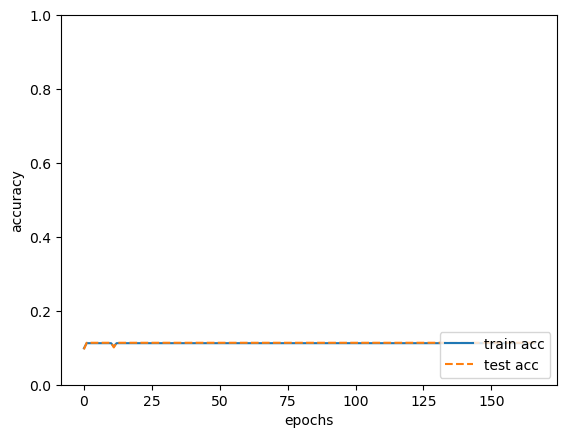

In [16]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# 아래는 기울기 소실이 발생하는 것으로 추측
# 기울기 소실이 아닌 가중치 초기값 설정 문제
# -> Xavier 초기값 적용 후 해보기로

```python
class TwoLayerNet:

    # 가중치 초기화
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.maxIndex = len(hidden_size)  # 입력층, 출력층 포함

        # 첫 번째 층
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size[0])
        self.params['b1'] = np.zeros(hidden_size[0])

        # 중간 층
        for i in range(1, self.maxIndex - 1):
            self.params['W' + str(i + 1)] = weight_init_std * np.random.randn(hidden_size[i - 1], hidden_size[i])
            self.params['b' + str(i + 1)] = np.zeros(hidden_size[i])

        # 마지막 층
        self.params['W' + str(self.maxIndex)] = weight_init_std * np.random.randn(hidden_size[-1], output_size)
        self.params['b' + str(self.maxIndex)] = np.zeros(output_size)

        # 모든 가중치 및 편향 출력 확인
        for key in self.params.keys():
            print(key)
        
        
    # 가중치와 편향으로 계산 신경망 계산
    def predict(self, x):
        a, z = {}, {}
    
        a["a1"] = np.dot(x, self.params['W1']) + self.params['b1']
        z["z1"] = sigmoid(a["a1"])
        
        for i in range(1, self.maxIndex - 1):
            a["a"+str(i+1)] = np.dot(z["z"+str(i)], self.params['W'+str(i+1)]) + self.params['b'+str(i+1)]
            z["z"+str(i+1)] = sigmoid(a["a"+str(i+1)])
        
        a["a"+str(self.maxIndex)] = np.dot(z["z"+str(self.maxIndex-1)], self.params['W'+str(self.maxIndex)]) + self.params['b'+str(self.maxIndex)]
        y = softmax(a["a"+str(self.maxIndex)])
        
        return y        
        
    # 교차 엔트로피 오차 손실 함수를 구한다
    def loss(self, x, t):
        # x : 입력 데이터, t : 정답 레이블
        y = self.predict(x)
        return cross_entropy_error(y, t)

    
    # 정확도 구하기
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 오차역전파법으로 기울기 구하기 -> 5장 학습 후 다시 보기
    def gradient(self, x, t):
        # 순전파 ~~~~~
        a, z = {}, {}
    
        a["a1"] = np.dot(x, self.params['W1']) + self.params['b1']
        z["z1"] = sigmoid(a["a1"])
        
        for i in range(1, self.maxIndex - 1):
            a["a"+str(i+1)] = np.dot(z["z"+str(i)], self.params['W'+str(i+1)]) + self.params['b'+str(i+1)]
            z["z"+str(i+1)] = sigmoid(a["a"+str(i+1)])
        
        a["a"+str(self.maxIndex)] = np.dot(z["z"+str(self.maxIndex-1)], self.params['W'+str(self.maxIndex)]) + self.params['b'+str(self.maxIndex)]
        y = softmax(a["a"+str(self.maxIndex)])
        
        # 역전파 ~~~~~
        grads = {}
           
        # 소프트맥스 
        batch_num = x.shape[0]
        dy = (y - t) / batch_num
        grads['W' + str(self.maxIndex)] = np.dot(z["z" + str(self.maxIndex - 1)].T, dy)
        grads['b' + str(self.maxIndex)] = np.sum(dy, axis=0)
        
        dz = dy
        for i in range(self.maxIndex-1, 1, -1):
            da = np.dot(dz, grads["W" + str(i + 1)].T)
            dz = sigmoid_grad(a["a" + str(i)]) * da
            grads['W' + str(i)] = np.dot(z["z" + str(i - 1)].T, dz)
            grads['b' + str(i)] = np.sum(dz, axis=0)
        
        # 시그모이드
        da = np.dot(dz, grads["W2"].T)
        dz = sigmoid_grad(a["a1"]) * da
        grads['W1'] = np.dot(x.T, dz)
        grads['b1'] = np.sum(dz, axis=0)
        
    
        # 시그모이드
        #grads['W3'] = np.dot(z["z2"].T, dy)
        #grads['b3'] = np.sum(dy, axis=0)
        
        # 시그모이드
        #da2 = np.dot(dy, grads["W3"].T)
        #dz2 = sigmoid_grad(a["a2"]) * da2
        #grads['W2'] = np.dot(z["z1"].T, dz2)
        #grads['b2'] = np.sum(dz2, axis=0)
        
        # 시그모이드
        #da1 = np.dot(dz2, grads["W2"].T)
        #dz1 = sigmoid_grad(a["a1"]) * da1
        #grads['W1'] = np.dot(x.T, dz1)
        #grads['b1'] = np.sum(dz1, axis=0)
           
        return grads
```